In [1]:
import math
import sys
import os
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib
from matplotlib import pyplot as plt
import time


sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "global/homes/l/lettieri/clevar/clevar")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")

import GCRCatalogs
#Put nersc if using nersc
GCRCatalogs.set_root_dir_by_site("nersc")
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

from clevar import ClCatalog, MemCatalog
from clevar.match import MembershipMatch, get_matched_pairs

from clevar.match import output_matched_catalog
import clevar

print('Clevar =', clevar.__version__)


# matplotlib.rcParams.update({'font.size': 22})
# matplotlib.rcParams.update({'figure.figsize': (10,8)})


GCRCatalogs = 1.9.0 | GCR = 0.9.2


/global/homes/l/lettieri/.local/lib/python3.13/site-packages/hpgeom-0.0.0-py3.13-linux-x86_64.egg/hpgeom/_hpgeom.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Clevar = 0.17.1


In [2]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_redmapper_v0.8.1')
gc_truth = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')  

In [3]:
quantities = gc.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]

In [4]:
# query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')   
cluster_data = Table(gc.get_quantities(cluster_quantities))
member_data = Table(gc.get_quantities(member_quantities))

In [5]:
# cluster_data[cluster_data['richness'] < 5]

In [6]:
min_halo_mass = 1e13 #Msun
redshift_max = 1.2

quantities_wanted = ['redshift','halo_mass','halo_id','galaxy_id','ra','dec', 'is_central', 'mag_true_u_lsst', 'mag_true_g_lsst', 'mag_true_r_lsst', 'mag_true_i_lsst', 'mag_true_z_lsst', 'mag_true_y_lsst']

query = GCRCatalogs.GCRQuery('(halo_mass > ' + str(min_halo_mass) +') & (redshift < ' + str(redshift_max) +')')
truth_data = Table(gc_truth.get_quantities(quantities_wanted, [query]))
#truth_data = Table.read('cosmoDC2_image_selected_data.fits')

In [7]:
RM_cat_name = 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
DC2_cat_name = 'cosmoDC2_v1.1.4_image'

#Redmapper
RM_cat = ClCatalog(RM_cat_name, z=cluster_data["redshift"], ra=cluster_data["ra"], dec=cluster_data["dec"], id = cluster_data["cluster_id"], richness = cluster_data["richness"], richness_err=cluster_data["richness_err"], \
                   id_cg = cluster_data["id_cen_0"], ztrue_cg=cluster_data["redshift_true_cg"], p_cg_0=cluster_data["p_cen_0"])

pmem = member_data["p_member"] * member_data["pfree_member"] * member_data["theta_i_member"] * member_data["theta_r_member"] 

member_data.add_column(pmem, name="pmem")

RM_cat_members = MemCatalog("RM_members", id_cluster=member_data["cluster_id_member"], id=member_data["id_member"], ra=member_data["ra_member"], dec=member_data["dec_member"],
                            pmem=member_data["pmem"],  redshift=member_data["redshift_true_member"], 
                            mag_g_lsst_member=member_data["mag_g_lsst_member"], mag_r_lsst_member=member_data["mag_r_lsst_member"], 
                            mag_i_lsst_member=member_data["mag_i_lsst_member"], mag_z_lsst_member=member_data["mag_z_lsst_member"], mag_y_lsst_member=member_data["mag_y_lsst_member"]) 

RM_cat.add_members(members_catalog=RM_cat_members)


#Dc2
halo_cat = ClCatalog(DC2_cat_name, z= truth_data["redshift"][truth_data["is_central"]],
                     ra= truth_data["ra"][truth_data["is_central"]], dec= truth_data["dec"][truth_data["is_central"]],
                     id=truth_data["halo_id"][truth_data["is_central"]], mass_fof=truth_data["halo_mass"][truth_data["is_central"]])

halo_cat_members = MemCatalog("halo_members", id_cluster=truth_data["halo_id"], id=truth_data["galaxy_id"], ra=truth_data["ra"], dec=truth_data["dec"],
                              redshift=truth_data["redshift"], is_central = truth_data["is_central"], 
                              mag_true_u_lsst = truth_data["mag_true_u_lsst"],  mag_true_g_lsst = truth_data["mag_true_g_lsst"],
                              mag_true_r_lsst = truth_data["mag_true_r_lsst"], mag_true_i_lsst = truth_data["mag_true_i_lsst"],  mag_true_z_lsst = truth_data["mag_true_z_lsst"], ) 

halo_cat.add_members(members_catalog=halo_cat_members)

RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

/global/homes/l/lettieri/.local/lib/python3.13/site-packages/clevar-0.17.1-py3.13.egg/clevar/catalog/catalog.py:745: UserWarning: Some galaxies were not members of the cluster catalog. They are stored in leftover_members attribute.
  warnings.warn(


In [8]:
# RM_cat_name = 'skysim5000_v1.1.1_redmapper_v0.8.5'
# DC2_cat_name = 'skysim5000_v1.1.1_image'

RM_cat_name = 'cosmoDC2_v1.1.4_redmapper_v0.8.1'
DC2_cat_name = 'cosmoDC2_v1.1.4_image'

RM_cat = ClCatalog(RM_cat_name, z=cluster_data["redshift"], ra=cluster_data["ra"], dec=cluster_data["dec"], id = cluster_data["cluster_id"], mass = cluster_data["richness"], richness_err=cluster_data["richness_err"], \
                   id_cg = cluster_data["id_cen_0"], ztrue_cg=cluster_data["redshift_true_cg"], p_cg_0=cluster_data["p_cen_0"])



In [9]:
display(RM_cat)

id,z,ra,dec,mass,richness_err,id_cg,ztrue_cg,p_cg_0
str11,float32,float64,float64,float32,float32,int64,float32,float32
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905
116,1.0629631,54.494027152041674,-27.896589555863095,76.85877,2.2175314,1940324795,1.0758829,0.6544826
133,1.037697,58.137368555958155,-27.199784884537003,75.89771,2.26323,2002528355,1.0311339,0.991116


In [10]:
RM_cat.write('RM_cat.fits', add_header =True, overwrite=True)

In [11]:
pmem = member_data["p_member"] * member_data["pfree_member"] * member_data["theta_i_member"] * member_data["theta_r_member"] 
member_data.replace_column("pmem",pmem) 

In [12]:
RM_cat_members = MemCatalog("RM_members", id_cluster=member_data["cluster_id_member"], id=member_data["id_member"], ra=member_data["ra_member"], dec=member_data["dec_member"],
                            pmem=member_data["pmem"],  redshift=member_data["redshift_true_member"], 
                            mag_g_lsst_member=member_data["mag_g_lsst_member"], mag_r_lsst_member=member_data["mag_r_lsst_member"], 
                            mag_i_lsst_member=member_data["mag_i_lsst_member"], mag_z_lsst_member=member_data["mag_z_lsst_member"], mag_y_lsst_member=member_data["mag_y_lsst_member"]) 
RM_cat.add_members(members_catalog=RM_cat_members)

# RM_cat.members.write('RM_cat_members.fits', overwrite=True)
RM_cat

id,z,ra,dec,mass,richness_err,id_cg,ztrue_cg,p_cg_0
str11,float32,float64,float64,float32,float32,int64,float32,float32
10,0.5135129,52.520436430812914,-25.717996124671657,190.70665,3.7469666,1312945563,0.51072353,0.79138356
18,0.5712697,56.920376528125075,-27.20434071042304,179.12813,3.6934361,2000524808,0.5740297,0.99996513
24,1.040338,56.99849698116052,-26.7172081871169,124.02715,2.4172914,2002535198,1.0347759,0.93527913
30,0.63518524,58.56362402841767,-27.429961828331713,167.33603,3.6777163,2000759779,0.6426174,0.9958548
71,0.44230303,58.35519782866568,-26.867687128773035,111.9147,3.366554,2000289335,0.43919736,0.7297119
73,0.46697217,57.76575707007693,-28.119101936484828,104.439766,2.9570596,2000290819,0.4680865,0.99970347
109,0.4413634,58.509466974185045,-26.989676182075844,103.49396,3.3524604,2000286447,0.44349608,0.99999905
116,1.0629631,54.494027152041674,-27.896589555863095,76.85877,2.2175314,1940324795,1.0758829,0.6544826
133,1.037697,58.137368555958155,-27.199784884537003,75.89771,2.26323,2002528355,1.0311339,0.991116


In [13]:
halo_cat = ClCatalog(DC2_cat_name, z= truth_data["redshift"][truth_data["is_central"]],
                     ra= truth_data["ra"][truth_data["is_central"]], dec= truth_data["dec"][truth_data["is_central"]],
                     id=truth_data["halo_id"][truth_data["is_central"]], mass=truth_data["halo_mass"][truth_data["is_central"]])
halo_cat

id,z,ra,dec,mass
str21,float64,float64,float64,float64
4500151475,0.04818676962281132,49.6366034309591,-40.400894272468605,16891355712901.41
7300151475,0.04825926322238838,50.957598308861314,-41.3447799174979,74621860826501.4
13700151475,0.04554516035339984,51.00887984172898,-40.832338501224754,33506664194163.383
1100151464,0.0643846735498792,50.57641425057562,-41.15855360868742,17911434075583.098
18300151442,0.10736840205357634,50.77601162448169,-39.168679326038024,13042641686354.93
36400151442,0.12743613052494784,50.60510200022939,-39.336294511446724,48388878878287.33
43700151442,0.11375834498747261,49.50475455575477,-40.23977306100707,69213477135143.664
52300151442,0.1259639067546261,51.070122482361214,-39.64548257286864,62974036412214.086
1200151432,0.12775858760889358,50.36982165635327,-39.09754001831282,34125997485791.55


In [14]:
# halo_cat.write('halo_cat.fits', overwrite=True)


In [15]:
halo_cat_members = MemCatalog("halo_members", id_cluster=truth_data["halo_id"], id=truth_data["galaxy_id"], ra=truth_data["ra"], dec=truth_data["dec"],
                              redshift=truth_data["redshift"], is_central = truth_data["is_central"], 
                              mag_true_u_lsst = truth_data["mag_true_u_lsst"],  mag_true_g_lsst = truth_data["mag_true_g_lsst"],
                              mag_true_r_lsst = truth_data["mag_true_r_lsst"], mag_true_i_lsst = truth_data["mag_true_i_lsst"],  mag_true_z_lsst = truth_data["mag_true_z_lsst"], )

In [16]:
halo_cat_members

id_cluster,id,ra,dec,redshift,is_central,mag_true_u_lsst,mag_true_g_lsst,mag_true_r_lsst,mag_true_i_lsst,mag_true_z_lsst
str21,str21,float64,float64,float64,bool,float32,float32,float32,float32,float32
4500151475,9437500128,49.6366034309591,-40.400894272468605,0.04818676962281132,True,17.104242,15.427202,14.594372,14.220104,13.957041
4500151475,9437500129,49.46521866823849,-40.41371737691802,0.04920109901409253,False,22.25664,21.199564,20.71225,20.43797,20.297253
4500151475,9437500130,49.62952487674635,-40.40525333868696,0.04825475916728461,False,17.41775,15.811033,15.01067,14.648596,14.410269
4500151475,9437500131,49.63722268629932,-40.40213407288883,0.04908434162264519,False,20.77637,19.294384,18.560036,18.194801,17.962835
4500151475,9437500132,49.47215142449812,-40.40661788509503,0.04715899608329677,False,20.729671,19.474966,19.085833,18.89763,18.833975
4500151475,9437500133,49.62774364073635,-40.389274415076976,0.04834164860201673,False,22.528042,21.259693,20.748756,20.500061,20.401487
4500151475,9437500134,49.7276378027726,-40.383940630337435,0.04834778668489825,False,19.053247,17.43881,16.642687,16.257164,16.007717
4500151475,9437500135,49.698541467041395,-40.27724451449116,0.04829776417102405,False,18.213757,17.159548,16.622149,16.261654,15.996252
4500151475,9437500136,49.718255793095075,-40.54445769390596,0.04739776740602353,False,22.01182,20.756655,20.328505,20.129255,20.065802


In [17]:
halo_cat.add_members(members_catalog=halo_cat_members)

In [18]:
# halo_cat.members.write('halo_cat_members.fits', overwrite=True)


In [19]:
#RM_cat = ClCatalog.read('RM_cat_richness_min_'+str(min_richness)+'.fits', name='RM_cat', full=True, tags={'mass':'richness'})
#halo_cat = ClCatalog.read('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'.fits', name='halo_cat', full=True, tags={'mass':'mass_fof'})



In [20]:
# RM_cat.read_members('RM_cat_richness_min_'+str(min_richness)+'_members.fits',  full=True)
# halo_cat.read_members('halo_cat_mass_min_'+f"{min_halo_mass:1.2e}"+'_members.fits', full=True)


In [21]:
RM_cat._init_match_vals(True)
halo_cat._init_match_vals(True)

In [22]:
mt = MembershipMatch()
match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'preference': 'shared_member_fraction', # other options are more_massive, angular_proximity or redshift_proximity
    'minimum_share_fraction': -0.5,
    'match_members_kwargs': {'method':'id'},
}
mt.match_from_config(RM_cat, halo_cat, match_config)


1,085,430 members were matched.

## Multiple match (catalog 1)
Finding candidates (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 43,106/45,081 objects matched.

## Multiple match (catalog 2)
Finding candidates (cosmoDC2_v1.1.4_image)
* 74,474/249,557 objects matched.

## Finding unique matches of catalog 1
Unique Matches (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 42,914/45,081 objects matched.

## Finding unique matches of catalog 2
Unique Matches (cosmoDC2_v1.1.4_image)
* 42,917/249,557 objects matched.
Cross Matches (cosmoDC2_v1.1.4_redmapper_v0.8.1)
* 42,914/45,081 objects matched.
Cross Matches (cosmoDC2_v1.1.4_image)
* 42,914/249,557 objects matched.


In [25]:
mt.save_matches(RM_cat, halo_cat, out_dir='cDC2_RM_match_cross_membership', overwrite=True)


In [27]:
mt.load_matches(RM_cat, halo_cat, out_dir='cDC2_RM_match_cross_membership')


cosmoDC2_v1.1.4_redmapper_v0.8.1
    * ClEvar used in matching: 0.17.1
 * Total objects:    45,081
 * multiple (self):  43,106
 * multiple (other): 43,106
 * unique (self):    42,914
 * unique (other):   42,917
 * cross:            42,914

cosmoDC2_v1.1.4_image
    * ClEvar used in matching: 0.17.1
 * Total objects:    249,557
 * multiple (self):  74,474
 * multiple (other): 74,474
 * unique (self):    42,917
 * unique (other):   42,914
 * cross:            42,914


In [45]:
#RM_cat_bij, halo_cat_bij = get_matched_pairs(RM_cat, halo_cat, 'cross')
{int(a) for a in halo_cat_bij['id']}
#halo_cat_bij['id']== 3696200176219
#halo_cat_bij[halo_cat_bij['id']== str(1162500021323)]
halo_cat_bij[halo_cat_bij['id']== str(3696200176219)]

In [26]:
RM_cat_bij.size, RM_cat_bij.size/RM_cat.size,  halo_cat_bij.size/halo_cat.size


(42914, 0.9519309687007831, 0.1719607143858918)

Text(0, 0.5, '$\\ln (\\lambda)$')

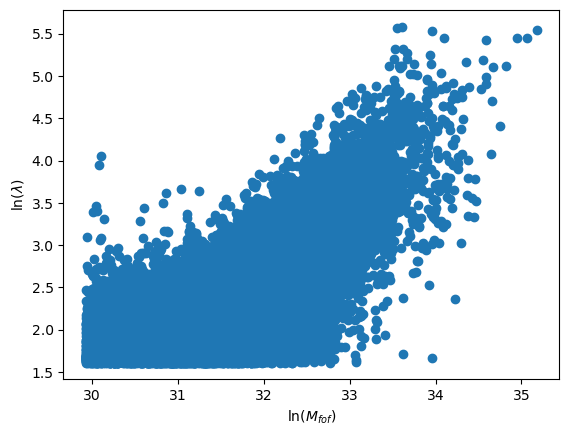

In [27]:
plt.scatter(np.log(halo_cat_bij['mass']),np.log(RM_cat_bij['mass']))
# plt.scatter(halo_cat_bij['mass_fof'],RM_cat_bij['richness'])

plt.xlabel('$\ln (M_{fof}$)')
plt.ylabel('$\ln (\lambda)$')

In [28]:
#Table([halo_cat_bij['mass'], RM_cat_bij['mass'], RM_cat_bij['z']])
RM_cat